### APPROACH

I have first mounted the whole dataset from the drive. Next, I have taken the image of a car and its respective video and matched the image with the frames of the video using ssim from skimage.metrics.structural_similarity. I have printed the first frame where the similarity is found and the similarity value

### Improvements in the work

To improve this work the results can be presented in a better way and various image processsing techniques and transfer learning models can be used but I have my university exams from Monday, that is 19 Dec so I counldn't devote more time to the task.

### Importing packages and Loading data

In [17]:
#importing all the required packages
import os
import glob
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import operator
import time
import datetime
import warnings
import cv2
from sys import stdout
from skimage import color
from skimage.metrics import structural_similarity as ssim

In [2]:
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive')
images ='/content/drive/MyDrive/Cars_Data/Cars_Data/images'

Mounted at /content/drive


### Visualizing the data

In [29]:
image_list = [os.listdir(images)]

In [4]:
image_list

[['10.png',
  '1.png',
  '11.png',
  '4.png',
  '3.png',
  '7.png',
  '5.png',
  '6.png',
  '2.png',
  '8.png',
  '9.png']]

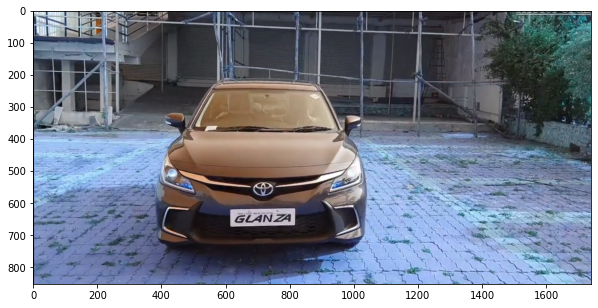

In [8]:
plt.figure(figsize = (10, 10))
image = cv2.imread('/content/drive/MyDrive/Cars_Data/Cars_Data/images/10.png', cv2.IMREAD_COLOR)
plt.imshow(image)

### Defining functions for preparing the image and parsing the videos along with matching the image with frames of all the videos

In [30]:
#record start time
start = time.time

#ignore non-contiguous skimage warning
warnings.filterwarnings("ignore", module="skimage")


def prepare_image(filename):
    #open still image as rgb
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    #shrink
    img = cv2.resize(img, (10, 10))
    #convert to b&w
    img = color.rgb2gray(img)
    return img


def best_match(similarities):
    d = max(similarities, key=lambda x:x['similarity'])
    best_frame_number = d['frame']
    best_similarity = d['similarity']
    return best_frame_number, best_similarity


def parse_video(image, video, n_matches=1, break_point=False, verbose=False):
    #iterate through video frames
    
    similarities = [{'frame': 0, 'similarity': 0}]
    frame_count = 0
    
    #get current time
    fps_time = time.time()

    cap = cv2.VideoCapture(video)
    while(cap.isOpened()):

        ret, frame = cap.read()

        #break at EOF
        if (type(frame) == type(None)):
            break

        #increment frame counter
        frame_count += 1

        #resize current video frame
        small_frame = cv2.resize(frame, (10, 10))
        #convert to greyscale
        small_frame_bw = color.rgb2gray(small_frame)

        #compare current frame to source image
        similarity = ssim(image, small_frame_bw)

        #remember current frame details
        similarities.append({'frame'      : frame_count,
                             'similarity' : similarity,
                             'image'      : frame})

        #find best match overall
        best_frame_number, best_similarity = best_match(similarities)
        
        #sort similarities list
        similarities = sorted(similarities, key=operator.itemgetter('similarity'), reverse=True)
        #remove surplus entries
        similarities = similarities[:n_matches]

        #calculate fps
        fps = frame_count / (time.time() - fps_time)

        #feedback to cli
        stdout.write('\r@ %d [%sfps] | best: %d (%s)  \r'
            % (frame_count, int(round(fps)), best_frame_number, round(best_similarity, 4), ))
        stdout.flush()

        #handle break_point
        if break_point:
            if similarity >= break_point:
                return similarities

    cap.release()
    return similarities


def sort_results(results, output=False):
    #sort results
    print ('\n')
    sorted_results = sorted(results, key=operator.itemgetter('similarity'), reverse=True)
    n = 0
    print ('\n--results:')
    for res in sorted_results:
        n += 1
        print ('#%s\t%s\t%s\t: %s' % (n, res['filename'], res['frame'], res['similarity']))

        #save matched frames
        if output:
            save_frame(output, n, res['image'])


def save_frame(filename, n, image):
    fn, ext = filename.split('.')
    fn = '%s_%s.%s' % (fn, n, ext)
    cv2.imwrite(fn, image)


def walk(source_image, directory, number=1, break_point=False):
    results = []
    extentions = ['mp4', 'avi', 'mov', 'mkv', 'm4v']
    for root, dirs, files in os.walk(directory):
        for file in files:
            for ext in extentions:
                if file.endswith(ext):
                    video_fn = (os.path.join(root, file))
                    print (video_fn)
                    similarities = parse_video(source_image,
                                               video_fn,
                                               n_matches=number,
                                               break_point=break_point)
                     
                    #flatten results
                    for d in similarities:
                        results.append({'filename'   : video_fn,
                                        'frame'      : d['frame'],
                                        'similarity' : d['similarity'],
                                        'image'      : d['image']})

                        #stop walk if break point achieved
                        if break_point:
                            if d['similarity'] >= break_point:
                                return results

    return results


def main():


    #prepare image
    img = prepare_image('/content/drive/MyDrive/Cars_Data/Cars_Data/images/1.png')
    directory = '/content/drive/MyDrive/Cars_Data/Cars_Data/videos/'
    
    if directory:
        #scan directory and process each video file
        print('\n--reading videos:')
        results = walk(img, directory)
        s_results = sort_results(results)

if __name__ == '__main__':
    main()





--reading videos:
/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car6.mp4
/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car5.mp4
/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car1.mp4
/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car4.mp4
/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car3.mp4
/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car2.mp4



--results:
#1	/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car6.mp4	362	: 0.9103142794785218
#2	/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car2.mp4	184	: 0.7001617761061998
#3	/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car1.mp4	187	: 0.6513805125797802
#4	/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car4.mp4	194	: 0.4845811828192791
#5	/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car3.mp4	72	: 0.42639380157318213
#6	/content/drive/MyDrive/Cars_Data/Cars_Data/videos/car5.mp4	391	: 0.2432457226678402


From the results we can infer that the video car6 and the image number 1 are the same as the similarity value for car6 is greater.